In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from itertools import combinations, permutations
from time import time
import pandas as pd
from numpy.random import random
# from orig_agg_util import *
#np.random.seed(890)
import warnings
warnings.filterwarnings('ignore')
from scipy.misc import comb
from scipy import stats
from scipy.spatial import distance
from agg_util import *
from fare.metrics import *
import seaborn as sns
from ir_metrics import *
import fairsearchcore as fsc
from yang_metrics import *

In [2]:
        #compare groups using statistical tests
    #     earthmover = stats.wasserstein_distance([groups[x-1] for x in y_pred], groups)[0]
    #     print("earthmover",earthmover) 
    
            #     kl = stats.entropy([groups[x-1] for x in y_pred], groups)
#     print("kl",kl)
#         hamming = distance.hamming(y, y_pred)
#     hamming = distance.hamming(groups, r_groups)[0]
#         m.append(hamming)

    #     cosine = distance.cosine(y, y_pred)
    #     cosine = distance.cosine(groups, r_groups)[0]
    #     m.append(cosine)
    #     jaccard = distance.jaccard(y, y_pred)
    # #     jaccard = distance.jaccard(groups, r_groups)[0]
    #     m.append(jaccard)
    
#     cosine ~= euclidean
# hamming~=jacard

In [3]:
def plot_heatmap(df):
    corr = df.corr()
    ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0,cmap=sns.diverging_palette(20, 220, n=200),square=True)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right')
    plt.show()

In [4]:
# p = 0.5 -> random, fair
# p large -> unfair favors g1

#for Yang methods
def gen_groups(n, p, ratio):
    len1 = int(n*ratio)
    len0 = n - len1
    groups = []
    while len1 > 0 and len0 >0:
        if random() < p: 
            groups.append(1)
            len1 -= 1
        else:
            groups.append(0)
            len0 -= 1
    while len1 > 0:
        groups.append(1)
        len1 -= 1
    while len0 >0:
        groups.append(0)
        len0 -= 1
    return groups

In [5]:
# p = 0.5 -> random, fair
# p large -> unfairly favors g1
# minority group is 0
def gen_minority_group_idx(n, p, ratio):
    len1 = int(n*ratio)
    len0 = n - len1
    idxs = []
    i=0
    while len1 > 0 and len0 >0:
        if random() < p: 
            len1 -= 1
        else:
            idxs.append(i)
            len0 -= 1
        i += 1
    while len1 > 0:
        len1 -= 1
        i += 1
    while len0 >0:
        idxs.append(i)
        len0 -= 1
        i+=1
    return idxs

In [6]:
# p = 0.5 -> random, fair
# p large -> unfair favors g1
def gen_groups_n(n, p, ratio):
    len1 = int(n*ratio)
    len0 = n - len1
    groups = []
    while len1 > 0 and len0 >0:
        if random() < p: 
            groups.append(1)
            len1 -= 1
        else:
            groups.append(0)
            len0 -= 1
    while len1 > 0:
        groups.append(1)
        len1 -= 1
    while len0 >0:
        groups.append(0)
        len0 -= 1
    return groups, len0

In [7]:
def get_metrics(ranks):

    y = np.array(range(len(ranks[0])))
    # m_names = ["parity","equality","calibration","pearson","spearman","kendall","kl","hamming","cosine","euclidean","jaccard"]
    m_names = ["parity","equality","calibration","kendall","pearson","spearman","kl","euclidean","ndcg_10","ndcg_50","ndcg_100"]
    ms =[]
    for y_pred in ranks:
        for p in [0.5,0.7,0.9]:
#             different size groups
            for ratio in [0.5, 0.7, 0.9]:
                groups = gen_groups(rank_len, p, ratio)
                m = []
                r_groups = [groups[x-1] for x in y_pred]

                # FARE metrics
                e0,e1 = rank_parity(y_pred,r_groups)
                parity = abs(e0-e1)
                m.append(parity)

                e0,e1 = rank_equality(y, y_pred, groups)
                equality = abs(e0-e1)
                m.append(equality)

                e0,e1 = rank_calibration(y, y_pred, groups)
                calibration = abs(e0-e1)
                m.append(calibration)

                kendall = stats.kendalltau(y, y_pred)[0]
                m.append(kendall)

                # Correlation coefficients
            #     pearson = stats.pearsonr(y, y_pred)[0]
                pearson = stats.pearsonr(groups, r_groups)[0]
                m.append(pearson)

                spearman = stats.spearmanr(y, y_pred)[0]
                (groups, r_groups)[0]
                m.append(spearman) 

                kl = stats.entropy(y, y_pred)
                (groups, r_groups)[0]
                m.append(kl)

                euclidean = distance.euclidean(y, y_pred)
            #     euclidean = distance.euclidean(groups, r_groups)[0]
                m.append(euclidean)

#   IR metrics
                ndcg_10 = ndcg_at_k(y_pred, 10)
                m.append(ndcg_10)
        
                ndcg_50 = ndcg_at_k(y_pred, 50)
                m.append(ndcg_50)
                
                ndcg_100 = ndcg_at_k(y_pred, 100)
                m.append(ndcg_100)
                
                ms.append(m)
            #     https://pypi.org/project/editdistance/0.3.1/
    return pd.DataFrame(ms, columns = m_names) 

In [8]:
# following https://github.com/fair-search/fairsearch-fair-python
# returns binary string  0 = not fair, 1 = fair

# possible that "compute_fail_probability" would give a fairness score? 
def get_fa_ir_metric(ranks):
    
    k = len(ranks[0]) # number of topK elements returned (value should be between 10 and 400)
    alpha = 0.1 # significance level (value should be between 0.01 and 0.15)
    m =[]
    for ratio in [0.5, 0.7, 0.9]:
        # create the Fair object 
        fair = fsc.Fair(k, ratio, alpha)
        # create an mtable using alpha adjusted
        mtable = fair.create_adjusted_mtable()
        for p in [0.5,0.7,0.9]:
            #  different size groups
            groups = gen_groups(rank_len, p, ratio)
            for y_pred in ranks:
                r_groups = np.array([groups[x-1] for x in y_pred], dtype=bool)
                fa_ir_rank = [fsc.models.FairScoreDoc(x-i, x-i, r_groups[i]) for i,x in enumerate(y_pred)]
                m.append(fair.is_fair(fa_ir_rank))
            #     https://pypi.org/project/editdistance/0.3.1/
    return np.array(m,dtype=int) 

In [9]:
# mallows data

# #(20,40),(100,1000),(300,50)
# n_ranks =100
# rank_len = 100
# p = 0.9
# theta = 0.1
# ranks = np.genfromtxt("data/R_n"+str(rank_len)+"_N"+str(n_ranks)+"_t"+str(theta)+".txt", delimiter=',', dtype=int)

In [10]:
# get Yang + stoyanavich metrics
# https://github.com/DataResponsibly/FairRank/blob/master/demo_measures.md

# Step 1: Specify the input population with size of user and protected group

# possible that "compute_fail_probability" would give a fairness score? 
def get_yang_metric(ranks, cut):
    
    # non-normalized fairness ffor now 
    max_rKL = 1
    max_rND = 1
    max_rRD = 1

#   method uses sliding window-like approach. this sets size of window
    cut_point = cut #int(len(ranks[0])/2) # the cut point of computation of fairness measures
    ms =[]
    for ratio in [0.5, 0.7, 0.9]:
        for p in [0.5,0.7,0.9]:
            m=[]
            groups = gen_minority_group_idx(rank_len, p, ratio)
            min_group = [i for i in groups]
            pro_N = len(min_group)
            for y_pred in ranks:
                fair_rKL = calculateNDFairness(test_ranking,min_group,cut_point,KL_DIVERGENCE,max_rKL)
                fair_rND = calculateNDFairness(test_ranking,min_group,cut_point,ND_DIFFERENCE,max_rND)
                fair_rRD = calculateNDFairness(test_ranking,min_group,cut_point,RD_DIFFERENCE,max_rRD)
                ms.append([fair_rKL,fair_rND,fair_rRD])
    
    return pd.DataFrame(ms, columns=["fair_rKL","fair_rND","fair_rRD"]) 

In [11]:
# random rankings

n_ranks =100
rank_len = 100

# make copy in format for fa_ir
ranks = []
for i in range(n_ranks):
    r = np.array(range(rank_len))
    np.random.shuffle(r)
    ranks.append(r)

np.shape(ranks)

(100, 100)

In [12]:
ms = get_metrics(ranks)
np.shape(ms)

(900, 11)

In [13]:
ms_fair = get_fa_ir_metric(ranks)

In [101]:
np.shape(ms_fair)

(900,)

In [102]:
ms.head()

,parity,equality,calibration,kendall,pearson,spearman,kl,euclidean,ndcg_10,ndcg_50,ndcg_100
0,0.007200,0.004000,0.013960,0.097374,4.000000e-02,0.141422,inf,378.261814,0.340706,0.509452,0.769414
1,0.742857,0.313810,0.036021,0.097374,3.965082e-17,0.141422,inf,378.261814,0.340706,0.509452,0.769414
2,0.886667,0.497778,0.053590,0.097374,-1.111111e-01,0.141422,inf,378.261814,0.340706,0.509452,0.769414
3,0.508800,0.242000,0.029262,0.097374,0.000000e+00,0.141422,inf,378.261814,0.340706,0.509452,0.769414
4,0.006667,0.095238,0.010424,0.097374,-1.904762e-01,0.141422,inf,378.261814,0.340706,0.509452,0.769414


In [103]:
ms["FA_IR"] = ms_fair

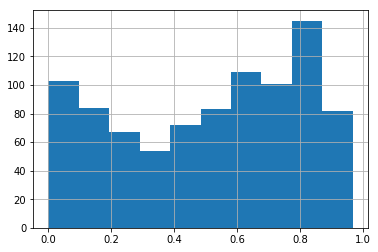

In [104]:
ms['parity'].hist()

In [122]:
ym = get_yang_metric(ranks,50)

In [123]:
ym.dtypes

fair_rKL    float64
fair_rND    float64
fair_rRD    float64
dtype: object

In [124]:
ms_all = pd.concat([ms,ym],axis=1)
ms_all.head()

,parity,equality,calibration,kendall,pearson,spearman,kl,euclidean,ndcg_10,ndcg_50,ndcg_100,FA_IR,fair_rKL,fair_rND,fair_rRD
0,0.007200,0.004000,0.013960,0.097374,4.000000e-02,0.141422,inf,378.261814,0.340706,0.509452,0.769414,1,0.001836,0.010577,0.037777
1,0.742857,0.313810,0.036021,0.097374,3.965082e-17,0.141422,inf,378.261814,0.340706,0.509452,0.769414,1,0.001836,0.010577,0.037777
2,0.886667,0.497778,0.053590,0.097374,-1.111111e-01,0.141422,inf,378.261814,0.340706,0.509452,0.769414,1,0.001836,0.010577,0.037777
3,0.508800,0.242000,0.029262,0.097374,0.000000e+00,0.141422,inf,378.261814,0.340706,0.509452,0.769414,1,0.001836,0.010577,0.037777
4,0.006667,0.095238,0.010424,0.097374,-1.904762e-01,0.141422,inf,378.261814,0.340706,0.509452,0.769414,1,0.001836,0.010577,0.037777


In [107]:
f = ["parity","equality","calibration","kendall", "FA_IR"]
c = ["pearson","spearman","kendall","kl"]

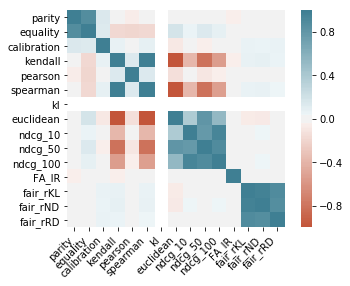

In [126]:
plot_heatmap(ms_all)

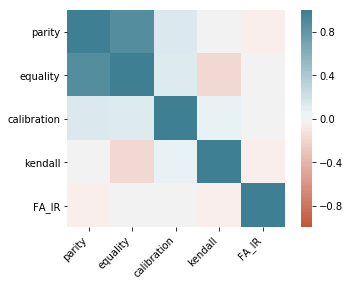

In [109]:
plot_heatmap(ms[f])

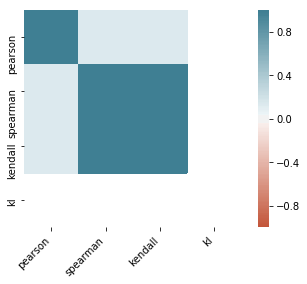

In [110]:
plot_heatmap(ms[c])

In [5]:
# get Yang + stoyanavich metrics
# https://github.com/DataResponsibly/FairRank/blob/master/demo_measures.md


# Step 1: Specify the input population with size of user and protected group
user_N = 100 
pro_N = 50

# # normalized fairness follow here  
# # if this input population has been computed, then get from recorded maximum (stored in normalizer.txt)      
# # else compute the normalizer of input population
# max_rKL = getNormalizer(user_N,pro_N,KL_DIVERGENCE)  
# max_rND = getNormalizer(user_N,pro_N,ND_DIFFERENCE)
# max_rRD = getNormalizer(user_N,pro_N,RD_DIFFERENCE)

# non-normalized fairness ffor now 
max_rKL = 1
max_rND = 1
max_rRD = 1
test_ranking = [x for x in range(user_N)]
pro_index = [x for x in range(pro_N)]

fair_rKL = calculateNDFairness(test_ranking,pro_index,cut_point,KL_DIVERGENCE,max_rKL)
fair_rND = calculateNDFairness(test_ranking,pro_index,cut_point,ND_DIFFERENCE,max_rND)
fair_rRD = calculateNDFairness(test_ranking,pro_index,cut_point,RD_DIFFERENCE,max_rRD)

print("rKL of test ranking is ", str(fair_rKL))
print("rND of test ranking is ", str(fair_rND))
print("rKL of test ranking is ", str(fair_rRD))